## Demand Model Building w/ Cross Validation

In this notebook, the static traffic count data is used to build a demand model across London 

In [3]:
import pandas as pd
import descartes
import geopandas as gpd
from geopandas import GeoDataFrame, GeoSeries
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
%matplotlib inline
import matplotlib as mpl

import seaborn as sns
from shapely.geometry import Point, Polygon
import numpy as np
import googlemaps
from datetime import datetime
plt.rcParams["figure.figsize"] = [8,6]
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [6]:
london = GeoDataFrame.from_file('/Users/johannesbreit/OneDrive - Imperial College London/irr/python model/'\
                                'lp-consultation-oct-2009-inner-outer-london-shp/'\
                                'lp-consultation-oct-2009-inner-outer-london.shp')
london

,Boundary,Source,Area_Ha,Shape_Leng,Shape_Area,geometry
0,Inner London,London Plan Consultation Draft,34863.295694,117020.737488,3.486330e+08,"POLYGON ((522055.5970999999 178014.7030999996,..."
1,Outer London,London Plan Consultation Draft,124606.812118,373367.664448,1.246068e+09,"POLYGON ((503611.1974999998 175520.3970999997,..."


,Boundary,Source,Area_Ha,Shape_Leng,Shape_Area,geometry
0,Inner London,London Plan Consultation Draft,34863.295694,117020.737488,3.486330e+08,POLYGON ((-0.2434430688990555 51.4879183844372...
1,Outer London,London Plan Consultation Draft,124606.812118,373367.664448,1.246068e+09,POLYGON ((-0.5097205869483654 51.4691750938383...


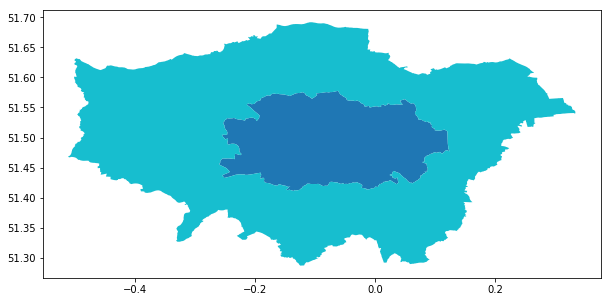

In [7]:
#converting Northing/Easting coordinates to lat/long
london = london.to_crs(epsg=4326)
fig, ax = plt.subplots(figsize = (10,10))
london.plot(ax= ax,column = 'Boundary')
london

I create a grid which spans the min and max values of both the longitude and latitude values of London. I manually calculate the distance between the min and max values and then divide this by 500, in order to get 500m x 500m grid elements.

In [8]:
##create a grid of london
ymax = 51.70
ymin = 51.25
xmax = 0.4
xmin = -0.6

#distance between (-0.1, 51.70 and -0.1, 51.25) = 50 km ymax
#distance between (-0.6, 51.5 and 0.4, 51.5) = 69 km xmax
#square grid would require 

xx, yy = np.meshgrid(np.linspace(xmin,xmax,int(69000/500)), np.linspace(ymin,ymax,int(50000/500)))
xc = xx.flatten()
yc = yy.flatten()

Create a GeoSeries with point values at of the long, lat pairs.

In [9]:
points = GeoSeries([Point(x, y) for x, y in zip(xc, yc)])

Keep only those points which fall inside the London GIS boundary and save as `in_map`.

In [10]:
in_map =  np.array([points.within(geom) for geom in london.geometry]).sum(axis=0)
in_map

array([0, 0, 0, ..., 0, 0, 0])

In [11]:
points = GeoSeries([val for pos,val in enumerate(points) if in_map[pos]])

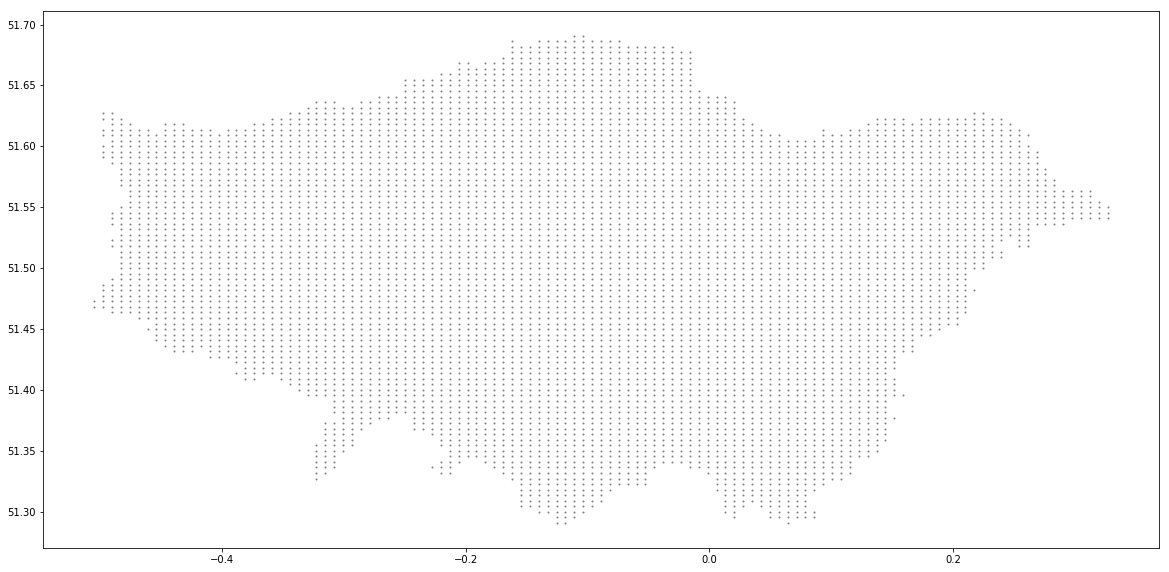

In [12]:
fig, ax = plt.subplots(figsize = (20,20))
points.plot(ax = ax, markersize = 1, color = 'grey')
plt.show()

## Traffic Data
I now load traffic count data and attempt to overlay it onto the created grid.

In [22]:
traffic = pd.read_csv('/Users/johannesbreit/OneDrive - Imperial College London/irr/IRR Datafiles/AADF-data-major-roads.csv')

traffic.head()

,AADFYear,CP,Estimation_method,Estimation_method_detailed,ONS GOR Name,ONS LA Name,Road,RCat,S Ref E,S Ref N,...,FdBUS,FdLGV,FdHGVR2,FdHGVR3,FdHGVR4,FdHGVA3,FdHGVA5,FdHGVA6,FdHGV,FdAll_MV
0,2000,51,Estimated,Estimated using previous year's AADF on this link,South West,Isles of Scilly,A3111,PA,90200,10585,...,25,451,30,0,0,0,0,0,30,1430
1,2000,52,Estimated,Estimated using previous year's AADF on this link,South West,Isles of Scilly,A3112,PA,91000,10240,...,16,250,11,0,0,0,0,0,11,1140
2,2000,53,Estimated,Estimated using previous year's AADF on this link,South West,Isles of Scilly,A3111,PA,91000,10775,...,16,264,15,0,0,0,0,0,15,884
3,2000,54,Estimated,Estimated using previous year's AADF on this link,South West,Isles of Scilly,A3110,PA,91515,10820,...,15,214,14,0,0,0,0,0,14,774
4,2000,55,Estimated,Estimated using previous year's AADF on this link,South West,Isles of Scilly,A3110,PA,91800,10890,...,22,77,27,0,0,0,0,0,27,557


#### Filter for only 2017 London Data

In [23]:
traffic_fil1 = traffic.loc[traffic['AADFYear'] == 2017][traffic['ONS GOR Name'] == 'London'].reset_index(drop=True)

/Users/johannesbreit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [25]:
columns = ['CP', 'ONS LA Name', 'S Ref Latitude', 'S Ref Longitude', 'FdCar']
traffic_fil2 = traffic_fil1.loc[:, columns]

In [26]:
crs = {'init' : 'epsg:4326'}
geometry = [Point(xy) for xy in zip(traffic_fil2['S Ref Longitude'], traffic_fil2['S Ref Latitude'])]
geometry[:3]

In [27]:
geo_df = gpd.GeoDataFrame(traffic_fil2, crs = crs, geometry = geometry)
geo_df.head(10)

,CP,ONS LA Name,S Ref Latitude,S Ref Longitude,FdCar,geometry
0,6000,Barnet,51.587521,-0.237953,37146,POINT (-0.237952792 51.58752074)
1,6001,Barnet,51.634688,-0.265315,57240,POINT (-0.265315076 51.63468794)
2,6013,Hillingdon,51.494067,-0.432722,110643,POINT (-0.432721583 51.49406703)
3,6071,Tower Hamlets,51.518228,-0.009866,74982,POINT (-0.009865919000000001 51.51822846)
4,6075,Islington,51.556605,-0.117539,24010,POINT (-0.11753935 51.55660547)
5,6076,Barnet,51.589078,-0.204257,90348,POINT (-0.204256905 51.58907824)
6,6077,Barnet,51.640848,-0.256264,47413,POINT (-0.256264113 51.64084841)
7,6094,Southwark,51.497614,-0.089716,9658,POINT (-0.08971587 51.49761428)
8,6095,Lewisham,51.475382,-0.028724,20458,POINT (-0.028723795 51.47538216)
9,6096,Greenwich,51.474500,0.023078,22749,POINT (0.023078428 51.47449974)


### 1) Split Dataset 80/20 for CV smoothing parameter selection

The optimal smoothing parameter will be used to approximate points for which there is no traffic count. The data set is split into a training/testing set to choose the parameter via cross-validation. 

In [28]:
from sklearn.model_selection import train_test_split
traffic_train, traffic_test = train_test_split(geo_df, test_size=0.2, random_state=42)

In [30]:
traffic_train = traffic_train.reset_index(drop=True)
traffic_test = traffic_test.reset_index(drop=True)

In [53]:
traffic_train.head()

,CP,ONS LA Name,S Ref Latitude,S Ref Longitude,FdCar,geometry
0,26465,Westminster,51.514327,-0.156323,9869,POINT (-0.156322691 51.51432728)
1,75101,Camden,51.518235,-0.119266,9229,POINT (-0.119266024 51.5182352)
2,75428,Waltham Forest,51.571293,0.015973,5284,POINT (0.015972923 51.57129344)
3,39035,Tower Hamlets,51.510734,-0.040658,52700,POINT (-0.040658364 51.51073448)
4,8280,Hillingdon,51.496800,-0.452955,47178,POINT (-0.452955206 51.49679953)


Construct dataframe of gridpoints:

In [52]:
grid_df = pd.DataFrame(points, columns = ['coordinate'])
grid_df['point'] = np.arange(1,len(grid_df)+1)
grid_df = grid_df[['point', 'coordinate']]
grid_df['traffic_count'] = np.zeros(len(grid_df))
grid_df.head()

,point,coordinate,traffic_count
0,1,POINT (-0.1255474452554745 51.29090909090909),0.0
1,2,POINT (-0.1182481751824818 51.29090909090909),0.0
2,3,POINT (0.06423357664233575 51.29090909090909),0.0
3,4,POINT (-0.1255474452554745 51.29545454545455),0.0
4,5,POINT (-0.1182481751824818 51.29545454545455),0.0


#### a) 1-NN Traffic-CP to Grid Point Assignment

In [49]:
from tqdm import tnrange, tqdm_notebook

In [54]:
for i in tqdm_notebook(range(len(traffic_train)), desc = 'Main Loop'):
    distances = pd.DataFrame(columns = ['geo_point','grid_point', 'distance'])
    for j in tqdm_notebook(range(len(grid_df)), desc = 'Sub-Loop', leave = False):
        distance = traffic_train.loc[i, 'geometry'].distance(grid_df.loc[j, 'coordinate'])
        to_append = pd.DataFrame([[traffic_train.loc[i, 'geometry'], grid_df.loc[j, 'coordinate'], distance]], \
                                 columns = ['geo_point', 'grid_point', 'distance'])
        distances = distances.append(to_append, ignore_index=True)

    index_min_distance = distances['distance'].idxmin()
    min_index_finder = (grid_df['coordinate'] == distances.loc[index_min_distance, 'grid_point']).reset_index()
    min_index = int(min_index_finder[min_index_finder["coordinate"] == True].index.values)
    grid_df.loc[min_index, 'traffic_count'] += traffic_train.loc[i, 'FdCar']
    #print(i)
    #print(grid_df.loc[min_index,:])

#### b) 1-NN Traffic-CP to Grid Point Assignment on Test Data

In [55]:
test_grid_df = pd.DataFrame(points, columns = ['coordinate'])
test_grid_df['point'] = np.arange(1,len(grid_df)+1)
test_grid_df = test_grid_df[['point', 'coordinate']]
test_grid_df['traffic_count'] = np.zeros(len(test_grid_df))
test_grid_df.head()

,point,coordinate,traffic_count
0,1,POINT (-0.1255474452554745 51.29090909090909),0.0
1,2,POINT (-0.1182481751824818 51.29090909090909),0.0
2,3,POINT (0.06423357664233575 51.29090909090909),0.0
3,4,POINT (-0.1255474452554745 51.29545454545455),0.0
4,5,POINT (-0.1182481751824818 51.29545454545455),0.0


In [56]:
for i in tqdm_notebook(range(len(traffic_test)), desc = 'Main Loop'):
    distances = pd.DataFrame(columns = ['geo_point','grid_point', 'distance'])
    for j in tqdm_notebook(range(len(test_grid_df)), desc = 'Sub-Loop', leave = False):
        distance = traffic_test.loc[i, 'geometry'].distance(test_grid_df.loc[j, 'coordinate'])
        to_append = pd.DataFrame([[traffic_test.loc[i, 'geometry'], test_grid_df.loc[j, 'coordinate'], distance]], \
                                 columns = ['geo_point', 'grid_point', 'distance'])
        distances = distances.append(to_append, ignore_index=True)

    index_min_distance = distances['distance'].idxmin()
    min_index_finder = (test_grid_df['coordinate'] == distances.loc[index_min_distance, 'grid_point']).reset_index()
    min_index = int(min_index_finder[min_index_finder["coordinate"] == True].index.values)
    test_grid_df.loc[min_index, 'traffic_count'] += traffic_test.loc[i, 'FdCar']

In [57]:
test_grid_df.head()

,point,coordinate,traffic_count
0,1,POINT (-0.1255474452554745 51.29090909090909),0.0
1,2,POINT (-0.1182481751824818 51.29090909090909),0.0
2,3,POINT (0.06423357664233575 51.29090909090909),0.0
3,4,POINT (-0.1255474452554745 51.29545454545455),0.0
4,5,POINT (-0.1182481751824818 51.29545454545455),0.0


In [59]:
## Save both files to CSV
grid_df.to_csv('train_grid_df.csv')
test_grid_df.to_csv('test_grid_df.csv')

### 2) Smooth train values by different smooth parameter 0 through 1 and find lowest RMSE on test values

a) Smooth all values in `traffic_train` by given parameter <br>
b) Truncate all negative demand values to 0  <br>
c) Take seperate dataframe which includes only those points which also occur in traffic_test<br>
d) Calculate RMSE between selected `traffic_train` smoothed values and `traffic_test` values

In [13]:
crs = {'init' : 'epsg:4326'}
train_grid = pd.read_csv('train_grid_df.csv')
train_grid = gpd.GeoDataFrame(train_grid, crs = crs, geometry = points)
train_grid = train_grid.drop(columns = 'Unnamed: 0')
train_grid.head()

,point,coordinate,traffic_count,geometry
0,1,POINT (-0.1255474452554745 51.29090909090909),0.0,POINT (-0.1255474452554745 51.29090909090909)
1,2,POINT (-0.1182481751824818 51.29090909090909),0.0,POINT (-0.1182481751824818 51.29090909090909)
2,3,POINT (0.06423357664233575 51.29090909090909),0.0,POINT (0.06423357664233575 51.29090909090909)
3,4,POINT (-0.1255474452554745 51.29545454545455),0.0,POINT (-0.1255474452554745 51.29545454545455)
4,5,POINT (-0.1182481751824818 51.29545454545455),0.0,POINT (-0.1182481751824818 51.29545454545455)


In [14]:
test_grid = pd.read_csv('test_grid_df.csv')
test_grid = gpd.GeoDataFrame(test_grid, crs = crs, geometry = points)
test_grid = test_grid.drop(columns = 'Unnamed: 0')
test_grid.head()

,point,coordinate,traffic_count,geometry
0,1,POINT (-0.1255474452554745 51.29090909090909),0.0,POINT (-0.1255474452554745 51.29090909090909)
1,2,POINT (-0.1182481751824818 51.29090909090909),0.0,POINT (-0.1182481751824818 51.29090909090909)
2,3,POINT (0.06423357664233575 51.29090909090909),0.0,POINT (0.06423357664233575 51.29090909090909)
3,4,POINT (-0.1255474452554745 51.29545454545455),0.0,POINT (-0.1255474452554745 51.29545454545455)
4,5,POINT (-0.1182481751824818 51.29545454545455),0.0,POINT (-0.1182481751824818 51.29545454545455)


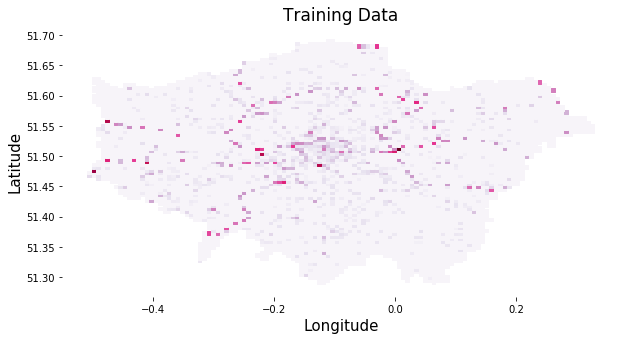

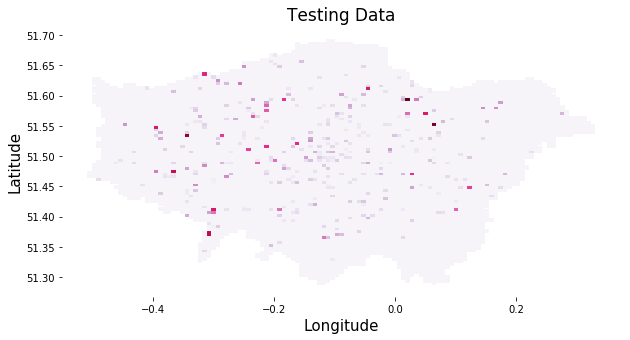

In [29]:
# fig, ax = plt.subplots(figsize = (15,20))
# train_grid.plot(ax = ax, markersize = 1, color = 'grey', marker= 'o')
# plt.show()

mpl.rcParams['image.cmap'] = 'PuRd'
fig,ax = plt.subplots(figsize = (10,10))
plt.box(on=None)
train_grid.plot(ax = ax, markersize = 12, c = train_grid.traffic_count, alpha = 1, marker = 's')
plt.ylabel('Latitude', fontsize = 15)
plt.xlabel('Longitude', fontsize = 15)
plt.title('Training Data', fontsize = 17)
plt.savefig('/Users/johannesbreit/OneDrive - Imperial College London/irr/python model/attempt2/TrainingData.svg')
plt.show()

mpl.rcParams['image.cmap'] = 'PuRd'
fig,ax = plt.subplots(figsize = (10,10))
plt.box(on=None)
test_grid.plot(ax = ax, markersize = 12, c = test_grid.traffic_count, alpha = 1, marker = 's')
plt.ylabel('Latitude', fontsize = 15)
plt.xlabel('Longitude', fontsize = 15)
plt.title('Testing Data', fontsize = 17)
plt.savefig('/Users/johannesbreit/OneDrive - Imperial College London/irr/python model/attempt2/TestingData.svg')
plt.show()

In [30]:
from scipy.interpolate import Rbf

In [31]:
x_coord = train_grid.geometry.apply(lambda p: p.x) 
y_coord = train_grid.geometry.apply(lambda p: p.y)
demand = train_grid.traffic_count 

coords = list(zip(list(x_coord), list(y_coord)))
test_grid['coords'] = coords
train_grid['coords'] = coords

test_grid_to_inner = test_grid.copy() #.loc[test_grid.traffic_count > 0]

In [295]:
param_error_dict = dict()
for smoothing_parameter in tqdm_notebook(np.arange(0,1.05,0.05), desc = 'Loop'):
    f = Rbf(x_coord, y_coord, demand, smooth=smoothing_parameter)
    smoothed_demand = f(x_coord, y_coord)
    
    train_grid['smoothed_demand'] = smoothed_demand
    trunc_demand = [count if count > 0 else 0 for count in smoothed_demand]
    train_grid['trunc_demand'] = trunc_demand
    
    inner_join = pd.merge(train_grid, test_grid_to_inner, on='coords', how='inner')
    
    SE = [(x - y)**2 for x, y in zip(inner_join.trunc_demand, inner_join.traffic_count_y)]
    RMSE = (sum(SE)/len(SE))**(1/2)
    
    param_error_dict[smoothing_parameter] = RMSE
    print(smoothing_parameter, RMSE)

0.0 27051.583208194832
0.05 22812.180549921275
0.1 22300.435426266868
0.15000000000000002 22070.72250317609
0.2 21941.916705264783
0.25 21863.22177469017
0.30000000000000004 21810.904193016973
0.35000000000000003 21776.03113469782
0.4 21751.999036258054
0.45 21735.855540674023
0.5 21723.9139877622
0.55 21715.04089426116
0.6000000000000001 21708.40977047606
0.65 21703.745514220223
0.7000000000000001 21701.01273715025
0.75 21699.765359717105
0.8 21699.6815477003
0.8500000000000001 21699.591897858336
0.9 21700.177652847382
0.9500000000000001 21701.494617369077
1.0 21703.384339300745


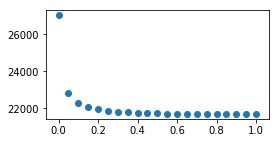

In [299]:
plt.subplots(figsize=(4,2))
plt.scatter(param_error_dict.keys(), param_error_dict.values())
plt.show()

In [300]:
min(param_error_dict, key=param_error_dict.get)

0.8500000000000001

### Build new complete dataframe with all demands in assigned cells and apply smoothing function with optimal parameter

Optimal parameter = 0.85

An innerjoin is used such that only the test values are added onto the full count. 

In [36]:
demand_grid = pd.merge(train_grid, test_grid, on='coords', how='inner')
demand_grid.head()

,point_x,coordinate_x,traffic_count_x,geometry_x,coords,point_y,coordinate_y,traffic_count_y,geometry_y
0,1,POINT (-0.1255474452554745 51.29090909090909),0.0,POINT (-0.1255474452554745 51.29090909090909),"(-0.12554744525547445, 51.29090909090909)",1,POINT (-0.1255474452554745 51.29090909090909),0.0,POINT (-0.1255474452554745 51.29090909090909)
1,2,POINT (-0.1182481751824818 51.29090909090909),0.0,POINT (-0.1182481751824818 51.29090909090909),"(-0.11824817518248176, 51.29090909090909)",2,POINT (-0.1182481751824818 51.29090909090909),0.0,POINT (-0.1182481751824818 51.29090909090909)
2,3,POINT (0.06423357664233575 51.29090909090909),0.0,POINT (0.06423357664233575 51.29090909090909),"(0.06423357664233575, 51.29090909090909)",3,POINT (0.06423357664233575 51.29090909090909),0.0,POINT (0.06423357664233575 51.29090909090909)
3,4,POINT (-0.1255474452554745 51.29545454545455),0.0,POINT (-0.1255474452554745 51.29545454545455),"(-0.12554744525547445, 51.29545454545455)",4,POINT (-0.1255474452554745 51.29545454545455),0.0,POINT (-0.1255474452554745 51.29545454545455)
4,5,POINT (-0.1182481751824818 51.29545454545455),0.0,POINT (-0.1182481751824818 51.29545454545455),"(-0.11824817518248176, 51.29545454545455)",5,POINT (-0.1182481751824818 51.29545454545455),0.0,POINT (-0.1182481751824818 51.29545454545455)


In [37]:
# columns_to_drop = ['coordinate_x', 'smoothed_demand', 'trunc_demand', 'point_y', 'coordinate_y', 'geometry_y']
columns_to_drop = ['coordinate_x', 'point_y', 'coordinate_y', 'geometry_y']
# demand_grid = demand_grid.drop(columns=columns_to_drop)
demand_grid = demand_grid.drop(columns=columns_to_drop)
demand = [(x + y) for x, y in zip(demand_grid.traffic_count_x, demand_grid.traffic_count_y)]
demand_grid['demand'] = demand 
demand_grid.head()

,point_x,traffic_count_x,geometry_x,coords,traffic_count_y,demand
0,1,0.0,POINT (-0.1255474452554745 51.29090909090909),"(-0.12554744525547445, 51.29090909090909)",0.0,0.0
1,2,0.0,POINT (-0.1182481751824818 51.29090909090909),"(-0.11824817518248176, 51.29090909090909)",0.0,0.0
2,3,0.0,POINT (0.06423357664233575 51.29090909090909),"(0.06423357664233575, 51.29090909090909)",0.0,0.0
3,4,0.0,POINT (-0.1255474452554745 51.29545454545455),"(-0.12554744525547445, 51.29545454545455)",0.0,0.0
4,5,0.0,POINT (-0.1182481751824818 51.29545454545455),"(-0.11824817518248176, 51.29545454545455)",0.0,0.0


In [38]:
demand_grid = demand_grid.rename(columns = {'point_x': 'point', 'geometry_x': 'geometry'})
demand_grid = demand_grid.drop(columns = ['traffic_count_x', 'traffic_count_y'])

In [39]:
demand_grid.head()

,point,geometry,coords,demand
0,1,POINT (-0.1255474452554745 51.29090909090909),"(-0.12554744525547445, 51.29090909090909)",0.0
1,2,POINT (-0.1182481751824818 51.29090909090909),"(-0.11824817518248176, 51.29090909090909)",0.0
2,3,POINT (0.06423357664233575 51.29090909090909),"(0.06423357664233575, 51.29090909090909)",0.0
3,4,POINT (-0.1255474452554745 51.29545454545455),"(-0.12554744525547445, 51.29545454545455)",0.0
4,5,POINT (-0.1182481751824818 51.29545454545455),"(-0.11824817518248176, 51.29545454545455)",0.0


#### Smooth now with 0.85

In [41]:
f = Rbf(x_coord, y_coord, demand_grid.demand, smooth=0.85)
smoothed_demand = f(x_coord, y_coord)
zeros = [1 for x in smoothed_demand if x < 0]
trunc_demand = [count if count > 0 else 0 for count in smoothed_demand]
demand_grid['smoothed_demand'] = smoothed_demand
demand_grid['trunc_demand'] = trunc_demand

In [42]:
demand_grid.head()

,point,geometry,coords,demand,smoothed_demand,trunc_demand
0,1,POINT (-0.1255474452554745 51.29090909090909),"(-0.12554744525547445, 51.29090909090909)",0.0,222.506584,222.506584
1,2,POINT (-0.1182481751824818 51.29090909090909),"(-0.11824817518248176, 51.29090909090909)",0.0,33.057287,33.057287
2,3,POINT (0.06423357664233575 51.29090909090909),"(0.06423357664233575, 51.29090909090909)",0.0,201.586406,201.586406
3,4,POINT (-0.1255474452554745 51.29545454545455),"(-0.12554744525547445, 51.29545454545455)",0.0,-28.495958,0.000000
4,5,POINT (-0.1182481751824818 51.29545454545455),"(-0.11824817518248176, 51.29545454545455)",0.0,-44.836666,0.000000


In [43]:
len(zeros)

1113

In [319]:
demand_grid.head()

,point,geometry,coords,demand,smoothed_demand,trunc_demand
0,1,POINT (-0.1255474452554745 51.29090909090909),"(-0.12554744525547445, 51.29090909090909)",0.0,222.506584,222.506584
1,2,POINT (-0.1182481751824818 51.29090909090909),"(-0.11824817518248176, 51.29090909090909)",0.0,33.057287,33.057287
2,3,POINT (0.06423357664233575 51.29090909090909),"(0.06423357664233575, 51.29090909090909)",0.0,201.586406,201.586406
3,4,POINT (-0.1255474452554745 51.29545454545455),"(-0.12554744525547445, 51.29545454545455)",0.0,-28.495958,0.000000
4,5,POINT (-0.1182481751824818 51.29545454545455),"(-0.11824817518248176, 51.29545454545455)",0.0,-44.836666,0.000000


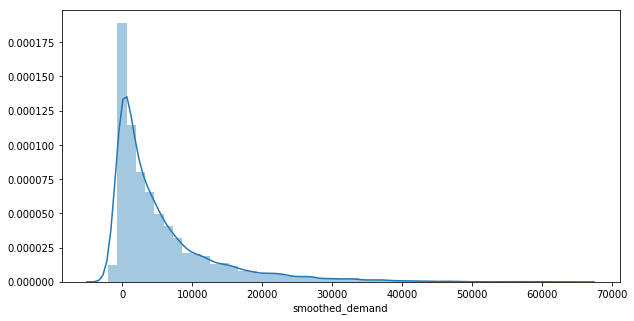

count     6235.000000
mean      5773.653888
std       7984.051048
min      -2048.644901
25%        479.156835
50%       2929.021455
75%       7787.819470
max      64524.723911
Name: smoothed_demand, dtype: float64
count     6235.000000
mean      5825.900633
std       7944.176838
min          0.000000
25%        479.156835
50%       2929.021455
75%       7787.819470
max      64524.723911
Name: trunc_demand, dtype: float64


In [324]:
##EDA
plt.subplots(figsize = (10,5))
sns.distplot(a = demand_grid.smoothed_demand)
plt.show()

print(demand_grid.smoothed_demand.describe())
print(demand_grid.trunc_demand.describe())

In [1]:
mpl.rcParams['image.cmap'] = 'PuRd'
fig,ax = plt.subplots(figsize = (16,16))
plt.ylabel('Latitude', fontsize = 12)
plt.xlabel('Longitude', fontsize = 12)
plt.title('Smoothed Vehicle Demand across London', fontsize = 14)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
demand_grid.plot(column = 'trunc_demand', ax = ax, markersize = 20, alpha = 1, \
                marker = 's', legend=True, cax = cax)
plt.ylabel('Demand scale', fontsize = 12)
#london.geometry.boundary.plot(color=None, edgecolor='k', linewidth = 1, ax=ax, alpha = 0.5)
plt.show()

NameError: name 'mpl' is not defined

In [345]:
#number of zero-demand cells
print('The number of zero-demand cells is {}' .format(len(demand_grid.loc[demand_grid.trunc_demand == 0])))

#Number of super high demand cells
print('The number of 30k+demand cells is {}' .format(len(demand_grid.loc[demand_grid.trunc_demand > 30000])))

The number of zero-demand cells is 1113
The number of 30k+demand cells is 140


In [351]:
##Write to CSV
demand_grid.to_csv('demand_grid_df.csv')

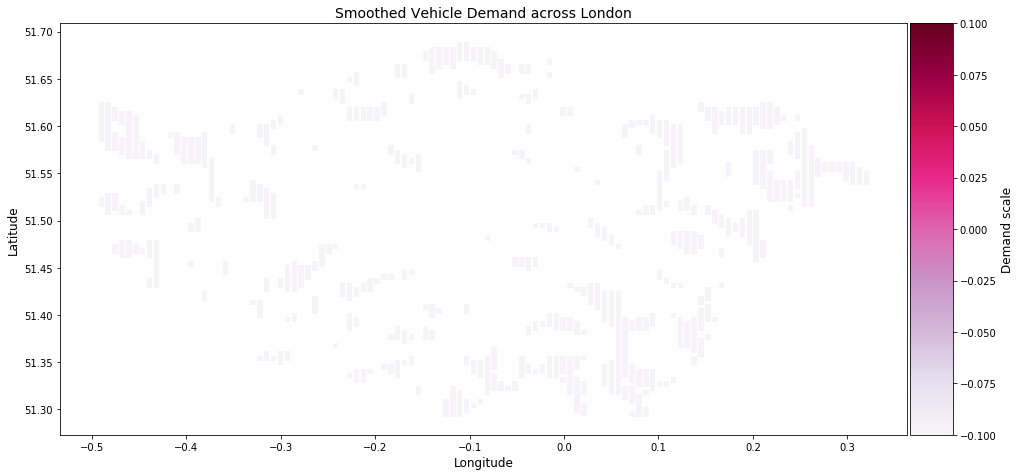

In [348]:
mpl.rcParams['image.cmap'] = 'PuRd'
fig,ax = plt.subplots(figsize = (16,16))
plt.ylabel('Latitude', fontsize = 12)
plt.xlabel('Longitude', fontsize = 12)
plt.title('Smoothed Vehicle Demand across London', fontsize = 14)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
demand_grid.loc[demand_grid.trunc_demand == 0].plot(column = 'trunc_demand', ax = ax, markersize = 20, alpha = 1, \
                marker = 's', legend=True, cax = cax)
plt.ylabel('Demand scale', fontsize = 12)
#london.geometry.boundary.plot(color=None, edgecolor='k', linewidth = 1, ax=ax, alpha = 0.5)
plt.show()

## This is now the traffic count smoothed data. Next step is to convert to energy demand.